# Writing an Oscillator in PyTorch

The core of sinusoidal modelling synthesis is the sinusoidal oscillator:

$$
\mathbf{y}[n] = \mathbf{a}[n] * \sin(\mathbf{\phi}[n])
$$

where $\mathbf{a}[n]$ and $\mathbf{\phi}[n]$ are amplitude and instaneous phase at the $n^\text{th}$ sample, respectively. 

However, we typically want to control an oscillation in terms of frequency instead of specifying
the instaneous phase directly.

Recall the relationship between frequency and phase:

$$
\omega = \frac{d\phi}{dt}
$$

Frequency is the derivative of phase. Therefore, phase can be calculated by integrating
the instaneous frequency and adding an intial phase offset:

$$
\mathbf{\phi}[n] = \phi_0 + \sum_{m=0}^{n}\mathbf{\omega}[m]
$$

where $\mathbf{\omega}[n]$ is the instantaneous angular frequency at the $n^\text{th}$ sample 
and $\phi_0$ is the initial phase.

Our final equation for our sinusoidal oscillator is:

$$
\mathbf{y}[n] = \mathbf{a}[n] * \sin(\phi_0 + \sum_{m=0}^{n}\mathbf{\omega}[m])
$$

### Different types of frequency

You might have noticed that we specified frequency, $\omega$, as angular frequency.
Angular frequency is in a normalized range of $[0, 2\pi]$.
When we're dealing with audio we'll also deal with frequency specified in Hertz (Hz).
For example, you might know that in the Western music tradition the A above middle C 
is tuned to 440Hz (or maybe [432Hz](https://soundofgoldenlight.com/432-hz/) is more your thing).

**How are frequency in Hertz and angular frequency related?**

When we're working with digital audio we are working with audio that is sampled at a particular sampling rate. 
For example, we're dealing with audio sampled at 16kHz in this notebook. 
The Nyquist theorem states that we can accurately represent audio frequencies up to 
half the sampling frequency. 
So if $f_s = 16000\text{Hz}$, we can accurately represent frequencies up to ${f_s}/{2} = 8000\text{Hz}$.

To determine angular frequency from a frequency in Hz we need to know the sampling rate
of the system and normalize such that $2\pi = f_s$. This means that the range
of angular frequencies that can be accurately represented fall in the range $[0,\pi]$.
Frequencies that are outside that range cause aliasing (incorrect representation of those frequencies).

$$
    \omega = 2\pi(\frac{f}{f_s})
$$

For a nice visual introduction and overview of some of these core DSP concepts we 
recommend Jack Schaedler's fantastic primer on the topic: [Seeing Circles, Sines, and Signals](https://jackschaedler.github.io/circles-sines-signals/index.html).


## Creating a Sinusoidal Oscillator

Let's write the above oscillator function using the PyTorch API.

We'll then look at how we can parameterize this oscillator and learn to match the
amplitude envelope of a target audio sample using gradient descent. Instead of using a
global amplitude parameter like we did in the previous chapter, we'll look at how we
can learn a time-varying amplitude envelope.

**A note on batching**

One of the benefits of using PyTorch is that it provides built-in support for hardware
acceleration such as GPUs which enable parallelization of computation. In practice, to
utilize this, we need to write our algorithms so that they support batches. Even though 
we're not using GPUs and our batch size is one in these notebooks, we include a batch
dimension to show what this looks like.

In [1]:
import torch
import IPython.display as ipd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
def sinusoid(
    amplitude: torch.Tensor,  # Amplitude (batch_size, n_steps)
    frequency: torch.Tensor,  # Angular frequency (batch_size, n_steps)
    phase: torch.Tensor = None,  # Initial phase (batch_size,), if None then 0
) -> torch.Tensor:
    """
    Implementational of a sinusoidal oscillator function. Receives time-varying
    amplitude and angular frequency as input and synthesizes a sinusoidal signal.
    An optional initial phase can also be specified.
    """
    # If initial phase is not specified, set it to 0
    if phase is None:
        phase = torch.zeros(amplitude.shape[0])

    # Unsqueeze the last dimension of phase to give it a time step dimension equal to 1
    # Then add the initial phase to the beginning of the angular frequency tensor
    # This sets the initial phase of the oscillator
    # We then discard the last element of the angular frequency tensor to maintain
    # the correct number of time steps
    phase = phase.unsqueeze(-1)
    frequency = torch.cat([phase, frequency], dim=1)[..., :-1]

    # Calulate the instantaneous phase by integrating the angular frequency.
    phase = torch.cumsum(frequency, dim=1)
    return amplitude * torch.sin(phase)

### Using our oscillator

To use our new sinusoidal oscillator we need to create the control arguments for the
function, which are tesnors time-varying angular frequency and amplitude values.

Let's first make a static tone at 440Hz at an audio sampling rate of 16kHz.

In [3]:
sample_rate = 16000  # Audio sampling rate
f0 = 440.0  # Frequency of the sinusoid in Hz

Make one second (16k samples) of angular frequency control signal. First create a
static signal at 440.0Hz, and then convert that to angular frequency, which has a range of $[0, 2\pi]$, where $2\pi$ is
the sampling rate.

In [4]:
frequency = torch.ones(1, sample_rate) * f0
frequency = frequency * 2 * torch.pi / sample_rate

Similarly, make a static amplitude signal with an amplitude of 0.5

In [5]:
amplitude = torch.ones(1, sample_rate) * 0.5

Synthesize it!

In [6]:
y = sinusoid(amplitude, frequency)
ipd.Audio(y[0].numpy(), rate=sample_rate, normalize=False)

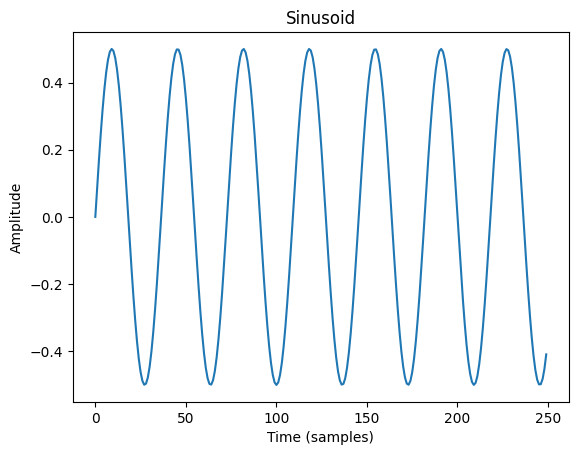

In [7]:
plt.plot(y[0, :250].numpy())
plt.title("Sinusoid")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

### Varying the frequency and amplitude

Because our amplitude and frequency tensors represent time-varying values, we can synthesize
a sound with modulating amplitude and frequency. For example, let's have the frequency
decrease by an octave from 440Hz to 220Hz over one second while the amplitude increases
from zero.

In [8]:
# Frequency envelope - Hz
frequency = torch.linspace(440, 220, sample_rate).unsqueeze(0)

# Convert to angular frequency - rads / sample
frequency = frequency * 2 * torch.pi / sample_rate

# Amplitude envelope
amplitude = torch.linspace(0, 1, sample_rate).unsqueeze(0)

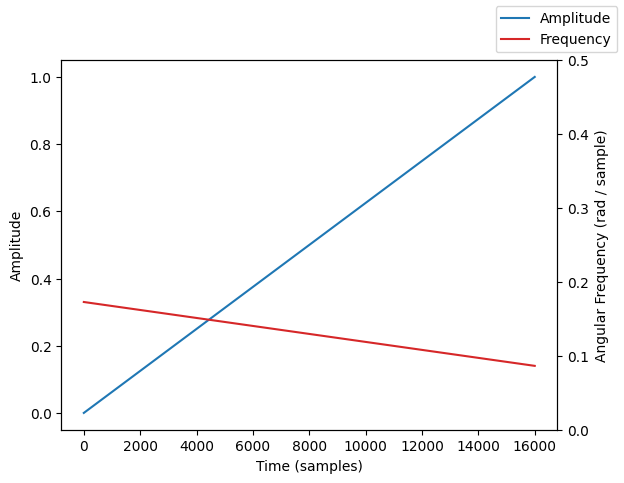

In [9]:
# Plot the amplitude and angular frequency envelopes
fig, ax1 = plt.subplots()

ax1.plot(amplitude[0].numpy(), color="tab:blue", label="Amplitude")
ax1.set_ylabel("Amplitude")
ax1.set_xlabel("Time (samples)")

ax2 = ax1.twinx()
ax2.plot(frequency[0].numpy(), color="tab:red", label="Frequency")
ax2.set_ylabel("Angular Frequency (rad / sample)")
ax2.set_ylim(0, 0.5)

fig.legend()
plt.show()

In [10]:
y = sinusoid(amplitude, frequency)
ipd.Audio(y[0].numpy(), rate=sample_rate, normalize=False)

## Optimizing parameters for our oscillator

Now we have a differentiable sinusoidal oscillator! 

Let's optimize the amplitude envelope to match a target audio.

Our target audio will be audio we just generated with the increasing amplitude and decreasing
frequency.

In [11]:
y = sinusoid(amplitude, frequency)

### Loss Functions

For our loss function we'll use an $L_1$ loss computed on the time domain
audio signal. Recall that this loss is sensetive to phase variances; however, we know
that phase will be identical between these signals because we're using the same frequency
envelope with zero initial phase.

### Amplitude Initialization
We'll create a random amplitude envelope that will serve as the parameter initialization prior
to optimization.

In [12]:
# Create a random amplitude envelope with 8 random points and interpolate it to the
# audio sampling rate
torch.random.manual_seed(0)
rand_amp = torch.rand(1, 1, 8)
rand_amp = torch.nn.functional.interpolate(
    rand_amp, size=(sample_rate), mode="linear"
).squeeze(0)

y_hat = sinusoid(rand_amp, frequency)

ipd.Audio(y_hat[0].numpy(), rate=sample_rate, normalize=False)

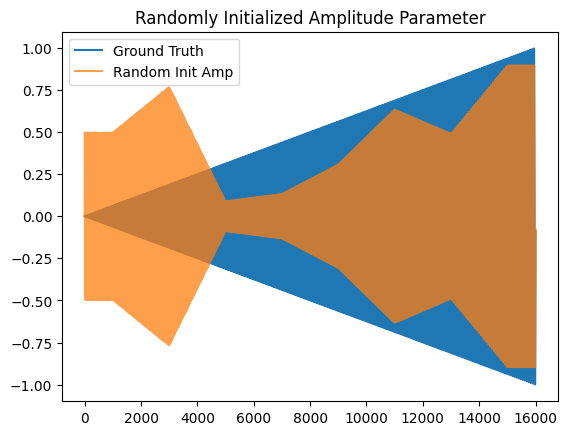

In [13]:
plt.plot(y[0].numpy(), label="Ground Truth")
plt.plot(y_hat[0].numpy(), alpha=0.75, label="Random Init Amp")
plt.legend()
plt.title("Randomly Initialized Amplitude Parameter")
plt.show()

### Create a PyTorch parameter and optimizer
Here we turn our intialized amplitude envelope into a PyTorch Parameter. This tells PyTorch
that we want to optimize these values and that it needs to compute gradients with respect to this tensor.
We'll also define an optimizer in this step and pass our amplitude parameters into the optimizer.

In [14]:
amp_param = torch.nn.Parameter(rand_amp)
optimizer = torch.optim.Adam([amp_param], lr=0.01)

### The optimization loop

In [15]:
loss_log = []
audio_log = []
for i in range(100):
    # Forward pass
    y_hat = sinusoid(amp_param, frequency)

    # Compute the loss
    loss = torch.nn.functional.l1_loss(y_hat, y)
    loss_log.append(loss.item())

    # Backward pass and optimization step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Save the audio
    if i % 5 == 0:
        audio_log.append(y_hat[0].detach().numpy())

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(y[0].numpy(), label="Ground Truth")

axes[1].set_ylim(0.0, max(loss_log))
axes[1].set_xlim(0, len(loss_log))

(line0,) = axes[0].plot([], [], lw=2, alpha=0.75)
(line1,) = axes[1].plot([], [], lw=2)

num_frames = len(audio_log)


def animate(i):
    iteration = i * 5

    axes[0].set_title("Iteration: {}".format(iteration))
    line0.set_data(torch.arange(sample_rate), audio_log[i])

    axes[1].set_title("Loss: {:.4f}".format(loss_log[iteration]))
    line1.set_data(torch.arange(iteration), loss_log[:iteration])

    return (
        line0,
        line1,
    )


# Create the animation
anim = FuncAnimation(fig, animate, frames=len(audio_log), interval=250, blit=True)

plt.close(fig)
# To display the animation in the Jupyter notebook:
display(ipd.HTML(anim.to_html5_video()))

### Results

Synthesize the result with the optimized amplitude parameter. It worked well! 

In [17]:
y_hat = sinusoid(amp_param, frequency)

# Now that the tensor is a learnable parameter, it is marked as requiring a gradient.
# We need to detach it from the computation graph before plotting and rendering audio.
ipd.Audio(y_hat[0].detach().numpy(), rate=sample_rate, normalize=True)

If you listen closely you'll hear a bit of noise from differences between sample-wise amplitude
values. This is related to the fact that we optimized an amplitude envelope at the audio sample rate.
In practice we don't expect our amplitude envelope to vary this quickly.
In a future section we'll look at specifying the amplitude at a lower rate (frame rate) which will
help create a smoother amplitude envelope and a parameter with fewer dimensions for optimization.

(sinusoidal-optimizing-challenge)=
## Optimizing Frequency

Great! We made a differentiable oscillator and we can use gradient descent to learn an
amplitude envelope to match a target.

**Now how about optimizing a frequency envelope?**

Unfortunately, we have encountered one of the fundamental open challenges in DDSP: **optimizing frequency**.

Due to the nature of sinusoidal functions, the gradient of our loss with respect to frequency parameters is periodic,
which means that the error landscape is full of nasty local minima. 

We can plot the $L_1$ spectral and waveform loss at various frequency values to visualize this.


In [18]:
def static_sin(frequency: float, num_samples: int, sample_rate: int):
    phase = torch.arange(num_samples).float() * frequency / sample_rate
    return torch.sin(phase * 2 * torch.pi)

In [19]:
def spectral_loss(x, y):
    x_fft = torch.fft.rfft(x).abs()
    y_fft = torch.fft.rfft(y).abs()
    return torch.nn.functional.l1_loss(x_fft, y_fft)

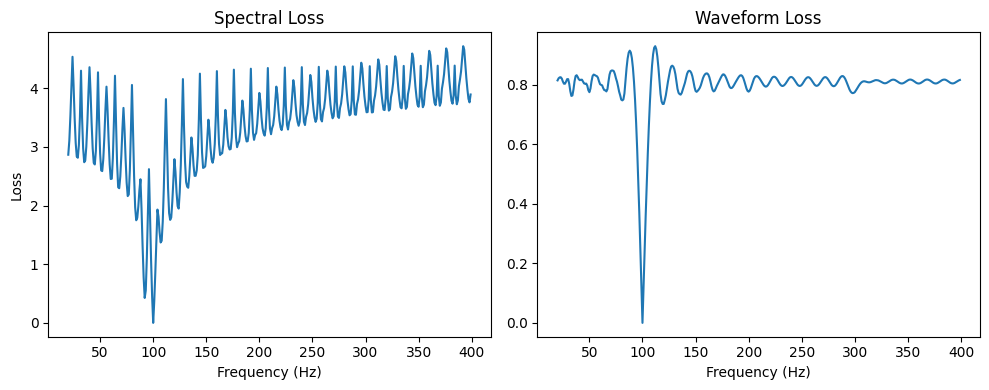

In [20]:
# Create a ground truth sinusoid with a frequency of 100 Hz
y = static_sin(100, 1000, sample_rate)

# Create a list of frequencies to test
freqs = list(range(20, 400))

s_loss = []
w_loss = []
for f in freqs:
    y_hat = static_sin(f, 1000, sample_rate)
    s_loss.append(spectral_loss(y_hat, y))
    w_loss.append(torch.nn.functional.l1_loss(y_hat, y))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(freqs, s_loss)
axes[0].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("Loss")
axes[0].set_title("Spectral Loss")

axes[1].plot(freqs, w_loss)
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_title("Waveform Loss")

plt.tight_layout()
plt.show()

These plots clearly show the correct value of 100Hz as a the global minimum. But the loss surface
is littered with local minima, which make gradient descent challenging.

While research is investigating solutions to this
problem, diving into this problem is beyond the scope of this part of tutorial.

Despite this problem, lot's of interesting work has been conducted in DDSP that doesn't rely
on directly learning frequencies of oscillators. In the next section we'll see how this
simple sinusoidal oscillator will form the basis of a more complex synthesizer that can
generate realistic instrumental sounds.

## Cummulative Summation and Numeric Errors

In these examples we are using torch's built-in `cumsum` function to calculate instantaneous
phase by integrating angular frequency. It is important to note that for longer audio clips
(~ >100k samples) this can lead to an accumulation of phase errors that can become audible
during these longer clips.

Engel et al. introduced an `angular_cumsum` method to deal with these accumulation errors.
This works by first chopping up an input frequency signal into blocks before computing
instaneous phase via integration, and then stitches the results together, taking into
account the required offsets between blocks to ensure a continuous phase signal.

For more information and code, check out their [implementation](https://github.com/magenta/ddsp/blob/7e0a39420f3bd87d9efd54cf0d36f4e258311340/ddsp/core.py#L800).

## Summary

In this section we looked at implementing a sinusoidal oscillator in PyTorch that was
capable of synthesizing a signal with time-varying amplitude and frequency. We looked
at how we can use gradient descent to learn to match an amplitude envelope. In contrast to amplitude,
optimizing frequency of a differentiable oscillator is a challenging problem due to the
presence of local minima.